Dry run of final experiment!

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from algorithms.langevin import *
from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import scipy
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import pickle
import plotnine as gg

import warnings
warnings.filterwarnings('ignore')

In [2]:
#pgts not quite right (dealing with constant term), fix this later

def plot_results(results):
    df = pd.DataFrame(results[0])
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    
def plot_results_list(results_list):
    for results in results_list:
        plot_results(results)

def simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    #env = FixedLogisticBandit(num_articles, dim, DistributionWithConstant(NormalDist(0,1,dim=dim-1),-2.5), DistributionWithConstant(BernoulliDist(5.0/(dim-1),dim-1)), seed=seed)
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(BernoulliDist(sparsity/dim,dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    cum_regrets = experiment.cum_regret
    if graph:
        plot_results(results)
    return results, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0, graph=False):
    results_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity, graph=graph)
        results_list += [results]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, cum_regrets_list, avg_regrets

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=seed, verbosity=verbosity, graph=graph)
    
"""def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets"""


'def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):\n    results_list = []\n    df_list = []\n    cum_regrets_list = []\n    avg_regrets = np.zeros(len(hyperparam_list))\n    for seed in range(seeds):\n        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]\n        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)\n        results_list += [results]\n        df_list += [df]\n        cum_regrets_list += [cum_regrets]\n        avg_regrets += cum_regrets\n    avg_regrets = avg_regrets / seeds\n    return results_list, df_list, cum_regrets_list, avg_regrets'

In [3]:
seed=1

num_articles = 100
dim = 100
dim1= dim+1
sparsity = 5.0
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=0

In [4]:
# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.

epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

## Online version

make_online_laplace_agent = lambda: OnlineDiagLaplaceTS(num_articles,dim1, [0]*dim1,
                                                        cov=None,init_pt=None,time=False,verbosity=0)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)
#self, num_articles, dim, intercept=False, context_has_constant=False, time=False, n_steps=100, verbosity=0

# Langevin-based

make_mala_agent = lambda: MalaTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)

## Untimed MALA agent is used as baseline.
## I don't know whether I should use 1+t or 1+\sqrt{sparsity/dim}*t

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim1, [0]*dim1, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

## With stochastic gradients


make_sgld_agent = lambda: SGLDTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(sparsity/dim)),
                                        batch_size = 64,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)
make_sagald_agent2 = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)
make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=verbosity)
make_prec_cum_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=verbosity)

In [5]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
agents = [make_sagald_agent(),make_sagald_agent2()]
results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547
 -0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
 -1.11731035  0.2344157   1.65980218  0.74204416 -0.19183555 -0.88762896
 -0.74715829  1.6924546   0.05080775 -0.63699565  0.19091548  2.10025514
  0.12015895  0.61720311  0.30017032 -0.35224985 -1.1425182  -0.34934272
 -0.20889423  0.58662319  0.83898341  0.93110208  0.28558733  0.88514116
 -0.75439794  1.25286816  0.51292982 -0.29809284  0.48851815 -0.07557171
  1.13162939  1.51981682  2.18557541 -1.39649634 -1.44411381 -0.50446586
  0.16003707  0.87616892  0.31563495 -2.02220122 -0.30620401  0.82797464
  0.23009474  0.76201118 -0.22232814 -0.2007580

Experiment: Step 337
Experiment: Step 338
Experiment: Step 339
Experiment: Step 340
Experiment: Step 341
Experiment: Step 342
Experiment: Step 343
Experiment: Step 344
Experiment: Step 345
Experiment: Step 346
Experiment: Step 347
Experiment: Step 348
Experiment: Step 349
Experiment: Step 350
Experiment: Step 351
Experiment: Step 352
Experiment: Step 353
Experiment: Step 354
Experiment: Step 355
Experiment: Step 356
Experiment: Step 357
Experiment: Step 358
Experiment: Step 359
Experiment: Step 360
Experiment: Step 361
Experiment: Step 362
Experiment: Step 363
Experiment: Step 364
Experiment: Step 365
Experiment: Step 366
Experiment: Step 367
Experiment: Step 368
Experiment: Step 369
Experiment: Step 370
Experiment: Step 371
Experiment: Step 372
Experiment: Step 373
Experiment: Step 374
Experiment: Step 375
Experiment: Step 376
Experiment: Step 377
Experiment: Step 378
Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: S

Experiment: Step 732
Experiment: Step 733
Experiment: Step 734
Experiment: Step 735
Experiment: Step 736
Experiment: Step 737
Experiment: Step 738
Experiment: Step 739
Experiment: Step 740
Experiment: Step 741
Experiment: Step 742
Experiment: Step 743
Experiment: Step 744
Experiment: Step 745
Experiment: Step 746
Experiment: Step 747
Experiment: Step 748
Experiment: Step 749
Experiment: Step 750
Experiment: Step 751
Experiment: Step 752
Experiment: Step 753
Experiment: Step 754
Experiment: Step 755
Experiment: Step 756
Experiment: Step 757
Experiment: Step 758
Experiment: Step 759
Experiment: Step 760
Experiment: Step 761
Experiment: Step 762
Experiment: Step 763
Experiment: Step 764
Experiment: Step 765
Experiment: Step 766
Experiment: Step 767
Experiment: Step 768
Experiment: Step 769
Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: S

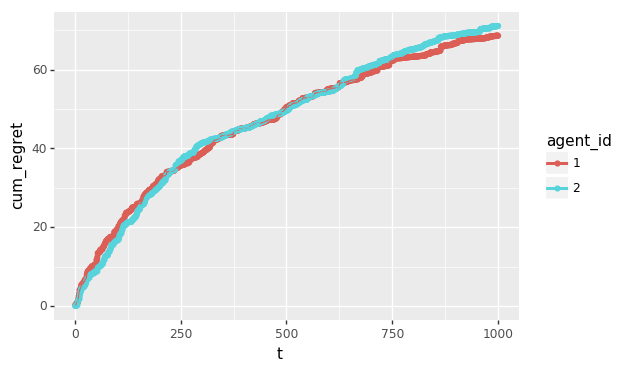

<ggplot: (8771299716245)>


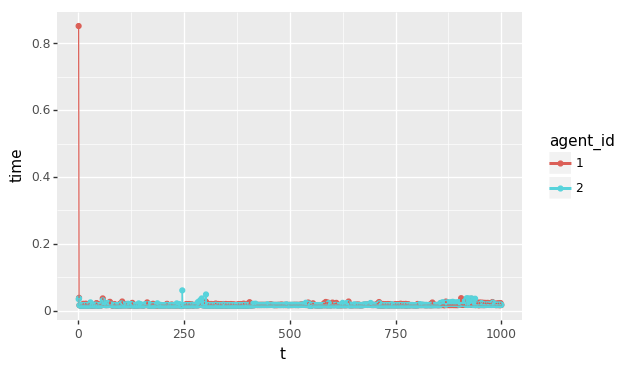

<ggplot: (8771472211445)>


In [6]:
plot_results(results)

In [8]:
make_sgld_agent_32 = lambda: SGLDTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(sparsity/dim)),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent_32 = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

agents2 = [make_online_laplace_agent(), make_sgld_agent(), make_sgld_agent_32(), make_sagald_agent(), make_sagald_agent_32()]
results2, cum_regrets2 = simple_compare(agents2, num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547
 -0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
 -1.11731035  0.2344157   1.65980218  0.74204416 -0.19183555 -0.88762896
 -0.74715829  1.6924546   0.05080775 -0.63699565  0.19091548  2.10025514
  0.12015895  0.61720311  0.30017032 -0.35224985 -1.1425182  -0.34934272
 -0.20889423  0.58662319  0.83898341  0.93110208  0.28558733  0.88514116
 -0.75439794  1.25286816  0.51292982 -0.29809284  0.48851815 -0.07557171
  1.13162939  1.51981682  2.18557541 -1.39649634 -1.44411381 -0.50446586
  0.16003707  0.87616892  0.31563495 -2.02220122 -0.30620401  0.82797464
  0.23009474  0.76201118 -0.22232814 -0.2007580

Experiment: Step 337
Experiment: Step 338
Experiment: Step 339
Experiment: Step 340
Experiment: Step 341
Experiment: Step 342
Experiment: Step 343
Experiment: Step 344
Experiment: Step 345
Experiment: Step 346
Experiment: Step 347
Experiment: Step 348
Experiment: Step 349
Experiment: Step 350
Experiment: Step 351
Experiment: Step 352
Experiment: Step 353
Experiment: Step 354
Experiment: Step 355
Experiment: Step 356
Experiment: Step 357
Experiment: Step 358
Experiment: Step 359
Experiment: Step 360
Experiment: Step 361
Experiment: Step 362
Experiment: Step 363
Experiment: Step 364
Experiment: Step 365
Experiment: Step 366
Experiment: Step 367
Experiment: Step 368
Experiment: Step 369
Experiment: Step 370
Experiment: Step 371
Experiment: Step 372
Experiment: Step 373
Experiment: Step 374
Experiment: Step 375
Experiment: Step 376
Experiment: Step 377
Experiment: Step 378
Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: S

Experiment: Step 728
Experiment: Step 729
Experiment: Step 730
Experiment: Step 731
Experiment: Step 732
Experiment: Step 733
Experiment: Step 734
Experiment: Step 735
Experiment: Step 736
Experiment: Step 737
Experiment: Step 738
Experiment: Step 739
Experiment: Step 740
Experiment: Step 741
Experiment: Step 742
Experiment: Step 743
Experiment: Step 744
Experiment: Step 745
Experiment: Step 746
Experiment: Step 747
Experiment: Step 748
Experiment: Step 749
Experiment: Step 750
Experiment: Step 751
Experiment: Step 752
Experiment: Step 753
Experiment: Step 754
Experiment: Step 755
Experiment: Step 756
Experiment: Step 757
Experiment: Step 758
Experiment: Step 759
Experiment: Step 760
Experiment: Step 761
Experiment: Step 762
Experiment: Step 763
Experiment: Step 764
Experiment: Step 765
Experiment: Step 766
Experiment: Step 767
Experiment: Step 768
Experiment: Step 769
Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: S

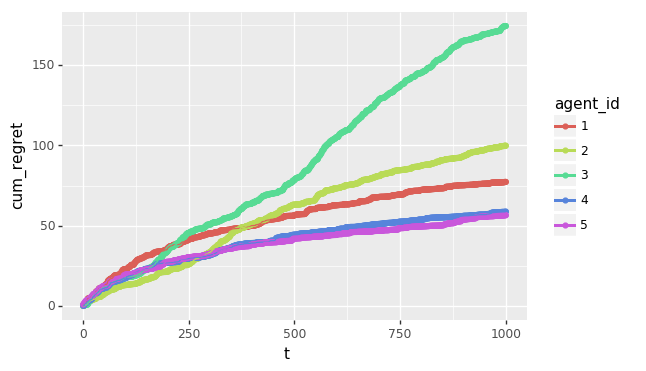

<ggplot: (8771471432125)>


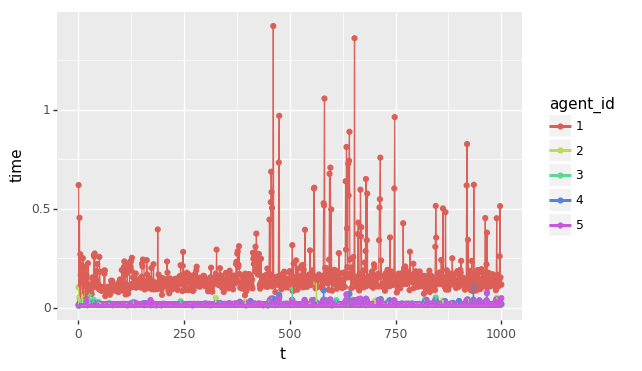

<ggplot: (8771500914065)>


In [10]:
plot_results(results2)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547
 -0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
 -1.11731035  0.2344157   1.65980218  0.74204416 -0.19183555 -0.88762896
 -0.74715829  1.6924546   0.05080775 -0.63699565  0.19091548  2.10025514
  0.12015895  0.61720311  0.30017032 -0.35224985 -1.1425182  -0.34934272
 -0.20889423  0.58662319  0.83898341  0.93110208  0.28558733  0.88514116
 -0.75439794  1.25286816  0.51292982 -0.29809284  0.48851815 -0.07557171
  1.13162939  1.51981682  2.18557541 -1.39649634 -1.44411381 -0.50446586
  0.16003707  0.87616892  0.31563495 -2.02220122 -0.30620401  0.82797464
  0.23009474  0.76201118 -0.22232814 -0.2007580

Experiment: Step 337
Experiment: Step 338
Experiment: Step 339
Experiment: Step 340
Experiment: Step 341
Experiment: Step 342
Experiment: Step 343
Experiment: Step 344
Experiment: Step 345
Experiment: Step 346
Experiment: Step 347
Experiment: Step 348
Experiment: Step 349
Experiment: Step 350
Experiment: Step 351
Experiment: Step 352
Experiment: Step 353
Experiment: Step 354
Experiment: Step 355
Experiment: Step 356
Experiment: Step 357
Experiment: Step 358
Experiment: Step 359
Experiment: Step 360
Experiment: Step 361
Experiment: Step 362
Experiment: Step 363
Experiment: Step 364
Experiment: Step 365
Experiment: Step 366
Experiment: Step 367
Experiment: Step 368
Experiment: Step 369
Experiment: Step 370
Experiment: Step 371
Experiment: Step 372
Experiment: Step 373
Experiment: Step 374
Experiment: Step 375
Experiment: Step 376
Experiment: Step 377
Experiment: Step 378
Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: S

Experiment: Step 730
Experiment: Step 731
Experiment: Step 732
Experiment: Step 733
Experiment: Step 734
Experiment: Step 735
Experiment: Step 736
Experiment: Step 737
Experiment: Step 738
Experiment: Step 739
Experiment: Step 740
Experiment: Step 741
Experiment: Step 742
Experiment: Step 743
Experiment: Step 744
Experiment: Step 745
Experiment: Step 746
Experiment: Step 747
Experiment: Step 748
Experiment: Step 749
Experiment: Step 750
Experiment: Step 751
Experiment: Step 752
Experiment: Step 753
Experiment: Step 754
Experiment: Step 755
Experiment: Step 756
Experiment: Step 757
Experiment: Step 758
Experiment: Step 759
Experiment: Step 760
Experiment: Step 761
Experiment: Step 762
Experiment: Step 763
Experiment: Step 764
Experiment: Step 765
Experiment: Step 766
Experiment: Step 767
Experiment: Step 768
Experiment: Step 769
Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: S

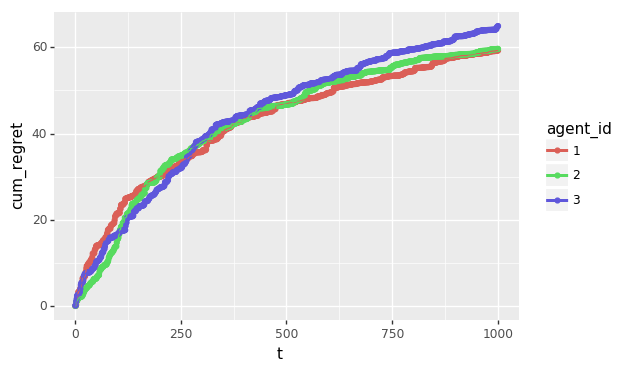

<ggplot: (8771296889865)>


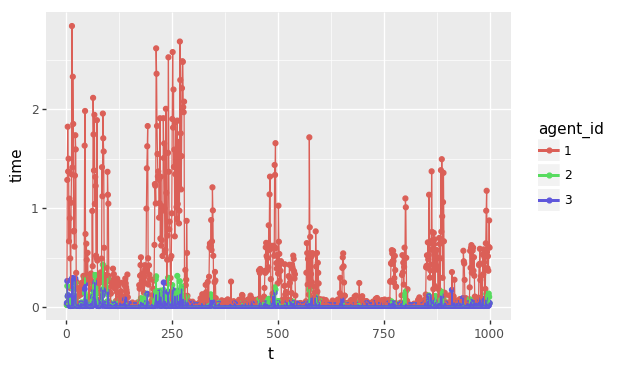

<ggplot: (8771471350925)>


In [11]:
agents3 = [make_pgts_agent(), make_sagald_agent(), make_sagald_agent_32()]
results3, cum_regrets3 = simple_compare(agents3, num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)
plot_results(results3)

In [12]:
results3

[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
 0             1        1     0.998341    0.007742        0.007742     1   
 1             2        2     0.998341    0.015688        0.015688     1   
 2             3        3     0.998341    0.131955        0.131955     1   
 3             4        1     1.997840    0.097777        0.090035     2   
 4             5        2     1.997840    0.034525        0.018837     2   
 5             6        3     1.997840    0.139588        0.007633     2   
 6             7        1     2.997612    0.287941        0.190164     3   
 7             8        2     2.997612    0.925668        0.891142     3   
 8             9        3     2.997612    1.030731        0.891142     3   
 9            10        1     3.996014    1.030084        0.742143     4   
 10           11        2     3.996014    1.164981        0.239313     4   
 11           12        3     3.996014    1.607364        0.576634     4   
 12         